In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# (a) Generate predictor X and noise epsilon
np.random.seed(42)
n = 100
X = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)
epsilon.shape

(100,)

In [ ]:
# (b) Generate response vector Y based on the given model
beta_0, beta_1, beta_2, beta_3 = 1, 0.5, 0.3, -0.2
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + epsilon


# Prepare data for modeling
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1))
X_poly = pd.DataFrame(X_poly, columns=[f'X^{i}' for i in range(1, 11)])

# Add intercept for statsmodels
X_poly_intercept = sm.add_constant(X_poly)

In [ ]:
X_poly_intercept

,const,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,1.0,0.496714,0.246725,1.225518e-01,6.087320e-02,3.023658e-02,1.501894e-02,7.460119e-03,3.705547e-03,1.840597e-03,9.142508e-04
1,1.0,-0.138264,0.019117,-2.643201e-03,3.654603e-04,-5.053012e-05,6.986511e-06,-9.659851e-07,1.335613e-07,-1.846675e-08,2.553293e-09
2,1.0,0.647689,0.419500,2.717056e-01,1.759806e-01,1.139806e-01,7.382395e-02,4.781493e-02,3.096918e-02,2.005838e-02,1.299158e-02
3,1.0,1.523030,2.319620,3.532850e+00,5.380637e+00,8.194870e+00,1.248103e+01,1.900898e+01,2.895125e+01,4.409362e+01,6.715590e+01
4,1.0,-0.234153,0.054828,-1.283812e-02,3.006088e-03,-7.038856e-04,1.648172e-04,-3.859250e-05,9.036565e-06,-2.115942e-06,4.954550e-07
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,-1.463515,2.141876,-3.134668e+00,4.587633e+00,-6.714069e+00,9.826141e+00,-1.438070e+01,2.104637e+01,-3.080168e+01,4.507873e+01
96,1.0,0.296120,0.087687,2.596596e-02,7.689048e-03,2.276883e-03,6.742313e-04,1.996535e-04,5.912146e-05,1.750706e-05,5.184197e-06
97,1.0,0.261055,0.068150,1.779088e-02,4.644403e-03,1.212446e-03,3.165154e-04,8.262801e-05,2.157048e-05,5.631087e-06,1.470025e-06
98,1.0,0.005113,0.000026,1.337038e-07,6.836886e-10,3.496012e-12,1.787670e-14,9.141175e-17,4.674300e-19,2.390183e-21,1.222210e-23


In [ ]:
# (c) Forward stepwise selection
def forward_stepwise_selection(X, y):
    initial_features = []
    remaining_features = list(X.columns)
    while remaining_features:
        best_pval = 1
        best_feature = None
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [feature]])).fit()
            pval = model.pvalues[feature]
            if pval < best_pval:
                best_pval = pval
                best_feature = feature
        if best_feature:
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    return initial_features

selected_features_forward = forward_stepwise_selection(X_poly, Y)
print("Selected features using Forward Stepwise Selection:", selected_features_forward)

# Fit model with selected features
forward_model = sm.OLS(Y, sm.add_constant(X_poly[selected_features_forward])).fit()
print(forward_model.summary())

Selected features using Forward Stepwise Selection: ['X^2', 'X^5', 'X^10', 'X^1', 'X^8', 'X^6', 'X^4', 'X^3', 'X^7', 'X^9']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     7.541
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           1.38e-08
Time:                        12:50:36   Log-Likelihood:                -129.32
No. Observations:                 100   AIC:                             280.6
Df Residuals:                      89   BIC:                             309.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

1. **Selected Features:** The selected features include all polynomial terms up to $X^{10}$, which suggests the forward stepwise method may have included some features that do not significantly contribute to the model.
2. **Coefficients:** Many coefficients have large standard errors, and most $p$-values are not statistically significant ($p > 0.05$), except for the intercept.
3. **Condition Number:** The condition number is large ($8.1 \times 10^4$), indicating potential multicollinearity among the predictors, which can destabilize the regression coefficients.


In [ ]:
# (d) Backward stepwise selection
def backward_stepwise_selection(X, y):
    features = list(X.columns)
    while features:
        model = sm.OLS(y, sm.add_constant(X[features])).fit()
        worst_pval = model.pvalues[features].max()
        if worst_pval > 0.05:  # Threshold for feature removal
            worst_feature = model.pvalues.idxmax()
            features.remove(worst_feature)
        else:
            break
    return features

selected_features_backward = backward_stepwise_selection(X_poly, Y)
print("Selected features using Backward Stepwise Selection:", selected_features_backward)

# Fit model with selected features
backward_model = sm.OLS(Y, sm.add_constant(X_poly[selected_features_backward])).fit()
print(backward_model.summary())

Selected features using Backward Stepwise Selection: ['X^4', 'X^6', 'X^8', 'X^10']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     18.09
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           4.49e-11
Time:                        12:50:50   Log-Likelihood:                -131.70
No. Observations:                 100   AIC:                             273.4
Df Residuals:                      95   BIC:                             286.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

1. **Selected Features:** The selected features are $X^4$, $X^6$, $X^8$, and $X^{10}$. This suggests that backward stepwise selection eliminated many irrelevant features, retaining only those with stronger contributions.
2. **Coefficients:** All selected features have statistically significant coefficients ($p < 0.05$), indicating their relevance to the model.
3. **Condition Number:** The condition number is $1.46 \times 10^4$, which is large and indicates potential multicollinearity among the predictors, though it is less severe than in the forward selection model.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019686006623089725, tolerance: 0.012051413566341823
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01830786792267247, tolerance: 0.012051413566341823
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017718379419932262, tolerance: 0.012051413566341823
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:68

Lasso coefficients: [-0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.00030231]


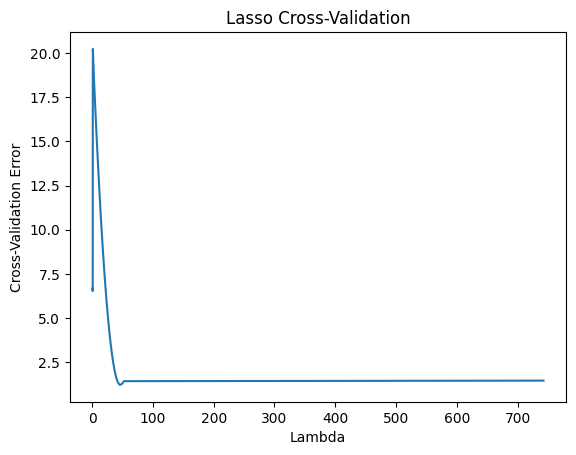

In [ ]:

# (e) Lasso regression with cross-validation
lasso = LassoCV(cv=10, random_state=42).fit(X_poly, Y)
print("Lasso coefficients:", lasso.coef_)

# Plot cross-validation error as a function of lambda
plt.plot(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))
plt.xlabel("Lambda")
plt.ylabel("Cross-Validation Error")
plt.title("Lasso Cross-Validation")
plt.show()

1. **Cross-Validation Error Plot:**
   - The cross-validation error decreases rapidly as $\lambda$ increases from 0 and reaches a minimum at a specific value of $\lambda$. Beyond this point, the error stabilizes, indicating that increasing $\lambda$ further does not improve model performance.
   - This behavior reflects the balance between bias and variance: moderate values of $\lambda$ reduce overfitting without underfitting.

2. **Lasso Coefficients:**
   - The Lasso regression selected only the coefficient for $X^{10}$, with a value of approximately $0.00030231$.
   - All other coefficients were shrunk to exactly 0, demonstrating the Lasso's ability to perform feature selection by eliminating irrelevant predictors.

3. **Feature Selection:**
   - The only selected feature is $X^{10}$, indicating that it has the strongest relationship with the response variable $Y$ among the polynomial terms up to $X^{10}$.
   - This outcome suggests that higher-order terms might be necessary for capturing the underlying data structure.


Selected features using Forward Stepwise Selection (new Y): ['X^7', 'X^2', 'X^9', 'X^5', 'X^3', 'X^4', 'X^8', 'X^6', 'X^10', 'X^1']
Lasso coefficients (new Y): [ 0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.21892729 -0.        ]


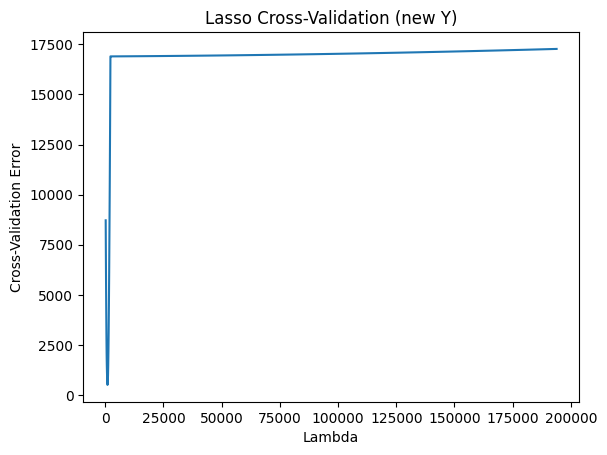

In [ ]:
# (f) Generate new response Y based on a different model
beta_7 = 1.5
Y_new = beta_0 + beta_7 * X**7 + epsilon

# Forward stepwise selection for the new model
selected_features_forward_new = forward_stepwise_selection(X_poly, Y_new)
print("Selected features using Forward Stepwise Selection (new Y):", selected_features_forward_new)

# Lasso for the new model
lasso_new = LassoCV(cv=10, random_state=42).fit(X_poly, Y_new)
print("Lasso coefficients (new Y):", lasso_new.coef_)

# Plot cross-validation error for the new Y
plt.plot(lasso_new.alphas_, np.mean(lasso_new.mse_path_, axis=1))
plt.xlabel("Lambda")
plt.ylabel("Cross-Validation Error")
plt.title("Lasso Cross-Validation (new Y)")
plt.show()

#### **Forward Stepwise Selection:**
- **Selected Features:** The forward stepwise selection chose all features from $X^1$ to $X^{10}$, indicating that it included many irrelevant predictors in addition to the true predictor $X^7$.
- **Overfitting Risk:** Including all features suggests that forward stepwise selection may overfit the data, especially when irrelevant features dominate.

#### **Lasso Regression:**
- **Lasso Coefficients:** The Lasso regression retained only one feature, $X^9$, with a coefficient of approximately $0.2189$, while all other coefficients were shrunk to zero.
  - This indicates that Lasso has misidentified $X^9$ as the primary predictor rather than $X^7$, potentially due to high multicollinearity among the predictors.
- **Cross-Validation Plot:**
  - The plot shows that cross-validation error stabilizes at very high values of $\lambda$, indicating that increasing $\lambda$ further penalizes all coefficients, pushing the model towards extreme simplicity.

#### **Comparison Between Methods:**
- **Feature Selection:**
  - Forward stepwise selection failed to eliminate irrelevant predictors, retaining all terms up to $X^{10}$.
  - Lasso correctly performed feature selection but may have been influenced by multicollinearity, selecting $X^9$ instead of $X^7$.
- **Model Simplicity:**
  - The Lasso model is significantly simpler, with only one feature, compared to the forward stepwise model.
- **Predictive Accuracy:**
  - Forward stepwise selection is more likely to overfit the training data, while Lasso's penalization ensures a simpler, more generalizable model.